## 1. Fillter (过滤型)

#### 1) Fillter方法运用相关性等指标对单个特征进行评分，评分高的特征优先被选择。

#### 2) Fillter方法选择过程独立于学习器，筛选出的特征对于模型泛化能力来说不一定是最优特征

#### 3) Fillter方法通过单变量统计来获取特征的内在属性，不考虑变量之间的关系

#### 4)  优缺点
- 优点：算法的通用性强，算法复杂度低，适用于大规模数据集；可快速去除大量不相关的特征，适合作为特征的预筛选器
- 缺点：倾向于选择冗余变量，因为它们不考虑变量之间的关系。

#### 5) 过滤型方法实例
- 无监督方法：方差阈
- 分类问题：卡方检验、mutual_info_classif、f_classif、信息增益
- 回归问题：相关系数、mutual_info_regression、f_regression

In [1]:
import numpy as np  
import pandas as pd
from sklearn.datasets import load_iris, load_boston, load_wine
from sklearn.feature_selection import *

rg = np.random.RandomState(2017)

row = 2500
X_reg = rg.randn(row, 4) 
name_reg = ['X0', 'X1', 'X2', 'X3']
y_reg = X_reg[:, 0] + np.sin(1.5*np.pi*X_reg[:, 1]) + np.cos(np.pi*X_reg[:, 2]) + np.tanh(np.pi*X_reg[:, 3])

def highlight(s):
    is_max = s == s.max()
    return ['color: red' if v else '' for v in is_max]

### 1.1 设置方差阈Variance Treshhold，移除方差低于阈值的特征，属于无监督方法

In [2]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X, y = load_boston(return_X_y=True)
X_scaled = scaler.fit_transform(X)
sel = VarianceThreshold(threshold=1)
X_sel = sel.fit_transform(X_scaled)
print('shape:{:}--->shape:{:}'.format(X_scaled.shape, X_sel.shape))

shape:(506, 13)--->shape:(506, 6)


### 1.2 卡方(Chi2)检验
- 只能用于非负特征、分类问题
- 卡方检验可用于检测非负特征与分类标签列的独立性，卡方统计量越大，两者越可能相互独立

In [3]:
iris = load_iris()
X, y = load_iris(return_X_y=True) 
iris_name = [i.replace(' (cm)', '').title() for i in iris.feature_names]
gus = GenericUnivariateSelect(score_func=chi2, mode='k_best', param=3)
gus.fit(X, y)

chi2_dict = {'Chi2':gus.scores_, 'Is_Support':gus.get_support()}
select_result = pd.DataFrame(chi2_dict, index=iris_name).sort_values(['Chi2'], ascending=False) 
select_result.style.apply(highlight, subset=['Is_Support'])

,Chi2,Is_Support
Petal Length,116.313,True
Petal Width,67.0484,True
Sepal Length,10.8178,True
Sepal Width,3.71073,False


### 1.3 Mutual information
- 能捕捉变量之间任何线性或非线性关系
- 其值越大表明变量之间的依赖性越强

####  mutual_info_classif：分类问题

In [4]:
X, y = load_iris(return_X_y=True)
gus = GenericUnivariateSelect(mutual_info_classif, mode='k_best', param=3)
gus.fit(X, y)

dict_ = {'Mutual_Info_Clf':gus.scores_, 'Is_Support':gus.get_support()}
select_result = pd.DataFrame(dict_, index=iris_name).sort_values(['Mutual_Info_Clf'], ascending=False) 
select_result.style.apply(highlight, subset=['Is_Support'])

,Mutual_Info_Clf,Is_Support
Petal Length,0.992963,True
Petal Width,0.98392,True
Sepal Length,0.499915,True
Sepal Width,0.276717,False


#### mutual_info_regression：回归问题

In [5]:
gus = GenericUnivariateSelect(mutual_info_regression, mode='k_best', param=3)
gus.fit(X_reg, y_reg)

dict_ = {'Mutual_Info_Reg':gus.scores_, 'Is_Support':gus.get_support()}
select_result = pd.DataFrame(dict_, index=name_reg).sort_values(['Mutual_Info_Reg'], ascending=False) 
select_result.style.apply(highlight, subset=['Is_Support'])

,Mutual_Info_Reg,Is_Support
X0,0.250728,True
X3,0.164805,True
X2,0.112816,True
X1,0.0968116,False


### 1.4 F检验：只能衡量线性关系

#### 分类问题：sklearn.feature_selection.f_classif(X, y)

In [6]:
gus = GenericUnivariateSelect(f_classif, mode='k_best', param=3)
X, y = load_iris(return_X_y=True)
gus.fit(X, y)

dict_ = {'f_classif':gus.scores_, 'Is_Support':gus.get_support()}
select_result = pd.DataFrame(dict_, index=iris_name).sort_values(['f_classif'], ascending=False) 
select_result.style.apply(highlight, subset=['Is_Support'])

,f_classif,Is_Support
Petal Length,1180.16,True
Petal Width,960.007,True
Sepal Length,119.265,True
Sepal Width,49.16,False


#### 回归问题：sklearn.feature_selection.f_regression(X, y, center=True)

In [7]:
from sklearn.feature_selection import f_regression
gus = GenericUnivariateSelect(f_regression, mode='k_best', param=3)
gus.fit(X_reg, y_reg)

dict_ = {'f_regression':gus.scores_, 'Is_Support':gus.get_support()}
select_result = pd.DataFrame(dict_, index=name_reg).sort_values(['f_regression'], ascending=False) 
select_result.style.apply(highlight, subset=['Is_Support'])

,f_regression,Is_Support
X0,1411.25,True
X3,705.047,True
X1,1.09176,True
X2,0.656064,False


### 1.5 Pearson相关系数：衡量两变量之间的线性关系，对非线性关系不敏感

In [8]:
from scipy.stats import pearsonr  
X, y = load_iris(return_X_y=True)
[float("%.3f" % pearsonr(X[:, i], y)[0]) for i in range(X.shape[1])]

[0.783, -0.427, 0.949, 0.957]

#### Person相关系数的缺点：对线性关系敏感。对于非线性关系，即使两个变量具有一一对应的关系，Pearson相关性也可能会接近0

In [9]:
x = rg.uniform(-5, 5, 100)  
y = [x**2, np.sin(abs(x)), np.log1p(abs(x))]
corr = [float('{:.6f}'.format(pearsonr(x, i)[0])) for i in y]
print("Pearsonr_corr:", corr)

Pearsonr_corr: [-0.13183, 0.124542, -0.09401]


### 1.6 各评价标准的对比

#### 在wine数据集上的对比

In [10]:
X, y = load_wine(return_X_y=True)
wine = load_wine()
func = [chi2, mutual_info_classif, f_classif]
func_name_1 = [i + '_score'for i in ['MI_clf', 'Chi2', 'F_classif']]
func_name_2 = [i + '_support'for i in ['MI_clf', 'Chi2', 'F_classif']]
select_result = pd.DataFrame(index=wine.feature_names)

for i, j in enumerate(func):
    gus = GenericUnivariateSelect(j, mode='k_best', param=10)
    gus.fit(X, y)
    select_result[func_name_1[i]] = gus.scores_
    select_result[func_name_2[i]] = gus.get_support()

select_result.sort_values(['MI_clf_score'], ascending=False, inplace=True) 
select_result[func_name_2].style.apply(highlight)

,MI_clf_support,Chi2_support,F_classif_support
proline,True,True,True
color_intensity,True,True,True
flavanoids,True,True,True
magnesium,True,False,False
alcalinity_of_ash,True,True,True
malic_acid,True,True,True
od280/od315_of_diluted_wines,True,True,True
total_phenols,True,True,True
proanthocyanins,True,True,True
alcohol,True,True,True


#### 在boston数据集上的对比

In [11]:
X, y = load_boston(return_X_y=True)
boston = load_boston()
func = [mutual_info_regression, f_regression]
func_name_1 = [i + '_score'for i in ['MI_Reg', 'F_regression']]
func_name_2 = [i + '_support'for i in ['MI_Reg', 'F_regression']]
select_result = pd.DataFrame(index=boston.feature_names)

for i, j in enumerate(func):
    gus = GenericUnivariateSelect(j, mode='k_best', param=10)
    gus.fit(X, y)
    select_result[func_name_1[i]] = gus.scores_
    select_result[func_name_2[i]] = gus.get_support()

select_result.sort_values(['MI_Reg_score'], ascending=False, inplace=True) 
select_result[func_name_2].style.apply(highlight)

,MI_Reg_support,F_regression_support
LSTAT,True,True
RM,True,True
NOX,True,True
INDUS,True,True
PTRATIO,True,True
TAX,True,True
CRIM,True,True
AGE,True,True
DIS,True,False
RAD,True,True


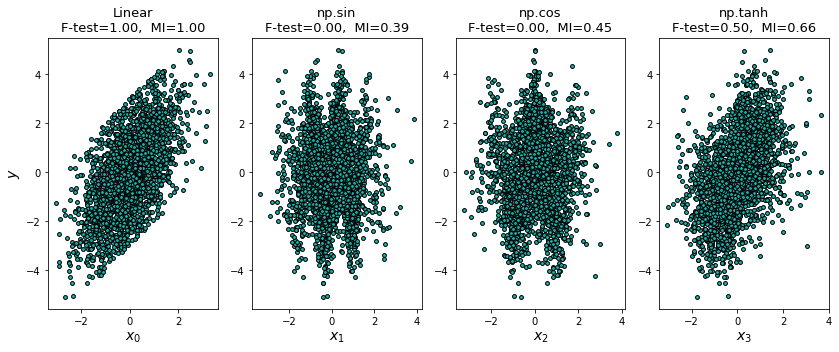

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

f_test, _ = f_regression(X_reg, y_reg)
f_test /= np.max(f_test)

mi = mutual_info_regression(X_reg, y_reg)
mi /= np.max(mi)

func = ['Linear', 'np.sin', 'np.cos', 'np.tanh']
plt.figure(figsize=(14, 5))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.scatter(X_reg[:, i], y_reg, edgecolor='black', s=15, c='lightseagreen')  #'teal' 'seagreen'
    plt.xlabel("$x_{}$".format(i), fontsize=14)
    if i == 0:
        plt.ylabel("$y$", fontsize=14)
    plt.title("{:}\nF-test={:.2f},  MI={:.2f}".format(func[i], f_test[i], mi[i]), fontsize=13)
plt.show()

## 2 wrapper : 封装（包裹）式，将学习器的性能表现作为特征子集的评价准则

#### 1) Wrapper methods assess subsets of variables according to their usefulness to a given predictor. In these methods, the subset selection takes place based on the learning algorithm used to train the model itself. Crudely speaking, every subset that is proposed by the subset selection measure is evaluated in the context of the learning algorithm.

#### 2) Wrapper methods consider the selection of a set of features as a search problem, where different combinations are prepared, evaluated and compared to other combinations. Obviously, this means that computationally intensive learning algorithms cannot be used due to the repeated learning steps and cross-validation. 

#### 3) Pros&Cons
- Pros: interaction between feature subset search and model selection, and the ability to take into account feature dependencies
- Cons: higher risk of overfitting than filter techniques and are very computationally intensive, especially if building the classifier has a high computational cost

#### 4) Wrapper methods:
- recursive feature elimination
- sequential feature selection algorithms
- genetic algorithms

### 2.1 递归特征删除：RFE(recursive feature elimination)

#### RFE通过外部模型评判各特征的重要性，逐步剔除重要性较小的特征来进行特征选择
- 通常运用回归模型返回的回归系数coef_、决策树模型返回的特征重要性feature_importances_来评估特征重要性
- 剔除回归系数或重要性较小的特征（剔除个数由step决定），再次训练模型
- 重复第二步，直到数据集中的特征数小于或等于n_features_to_select

#### sklearn.feature_selection.RFECV(estimator, step=1, cv=None, scoring=None, verbose=0, n_jobs=1)
- 通过交叉验证选取最佳的特征数
- estimator: 监督模型，且fit方法能提供coef_属性或feature_importances_属性来评估特征重要性
- step: int or float, optional (default=1)，每次迭代后删除的特征数或特征占比

In [13]:
from sklearn.feature_selection import RFE, RFECV  
from sklearn.linear_model import LinearRegression  
from xgboost import XGBRegressor
  
    
boston = load_boston()  
X, y = load_boston(return_X_y=True)
feature_name = boston.feature_names
xgb = XGBRegressor(learning_rate=0.15, n_estimators=150, random_state=2017)
RFECV_xgb = RFECV(xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
RFECV_xgb.fit(X, y)
print('RFECV_XGB确定的最佳特征数:', RFECV_xgb.n_features_)

# RFECV_xgb.grid_scores_ 交叉验证分数与特征是否被选择的关系不明显
rfe_dict = {'Support':RFECV_xgb.support_, 'Ranking':RFECV_xgb.ranking_}
rfe_res = pd.DataFrame(rfe_dict, index=boston.feature_names)
rfe_res.sort_values('Ranking', inplace=True)
rfe_res.style.apply(highlight, subset=['Support'])

RFECV_XGB确定的最佳特征数: 9


,Support,Ranking
CRIM,True,1
INDUS,True,1
NOX,True,1
RM,True,1
AGE,True,1
DIS,True,1
TAX,True,1
B,True,1
LSTAT,True,1
PTRATIO,False,2


#### sklearn.feature_selection.RFE(estimator, n_features_to_select=None, step=1, verbose=0)

- estimator: 监督模型，且fit方法能提供coef_属性或feature_importances_属性来评估特征重要性
- n_features_to_select：指定保留的特征数，若未指定，则保留一半的特征

In [14]:
lr = LinearRegression()  

# 保留10个特征
rfe_lr = RFE(lr, n_features_to_select=10).fit(X, y)  
rfe_xgb = RFE(xgb, n_features_to_select=10).fit(X, y)

dict_ = {'LR_ranking':rfe_lr.ranking_, 
         'LR_support':rfe_lr.support_, 
         'XGB_ranking':rfe_xgb.ranking_, 
         'XGB_support':rfe_xgb.support_}

RFE_df = pd.DataFrame(data=dict_, index=feature_name)
RFE_df.sort_values(['LR_ranking'], inplace=True)

def color_negative_red(val):
    color = 'red' if val == 1 else 'black'
    return 'color: %s' % color

# lr_ranking=1或lr_support=True，表示此特征被选择
# 可见不同的模型对特征重要性的评估结果可能不同
RFE_df.style.applymap(color_negative_red)

,LR_ranking,LR_support,XGB_ranking,XGB_support
CRIM,1,True,1,True
ZN,1,True,2,False
INDUS,1,True,1,True
CHAS,1,True,4,False
NOX,1,True,1,True
RM,1,True,1,True
DIS,1,True,1,True
RAD,1,True,3,False
PTRATIO,1,True,1,True
LSTAT,1,True,1,True


### 3 Embbed：嵌入式

#### 1) 嵌入式特征选择：特征选择过程与模型训练过程融为一体，两者在同一个优化过程中完成，即在模型训练过程中同时进行了特征选择

#### 2) Embedded methods与wrapper methods的区别：在模型训练过程中是否具备内生性的特征评价准则

#### 3) Pros&Cons
- **优点:** Embedded methods相比Wrapper methods的计算消耗更少
- **缺点:** 仅限于特定的机器学习算法（specific to a learning machine）

#### 4) Examples
- L1正则化：典型的嵌入式特征选择方法，能有效降低过拟合风险
- 决策树
- 神经网络

#### 5) API：sklearn.feature_selection.SelectFromModel(estimator, threshold=None, prefit=False, norm_order=1)
- 根据反应特征重要性的参数选择特征
- estimator： 模型必须具有feature_importances_ 或者coef_ attribute这里反应特征重要性的属性
- threshold ：大于等于阈值的特征被保留，默认取'mean'，还可取'median'，以及'1.25*mean'、标量等形式

### 3.1 基于L1正则化进行特征选择
- L1正则化是不稳定的，如果特征集合中具有共线性特征，则共线性特征可能只保留了一个，没有被选择到的特征不代表不重要
- 如果要确定哪个特征重要，应再通过L2正则方法交叉检验

In [15]:
from sklearn.svm import LinearSVC
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

cancer = load_breast_cancer()
X, y = load_breast_cancer(return_X_y=True)
X_scaled = StandardScaler().fit_transform(X)

# 基于L1正则化的特征选择
clf = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_scaled, y)
model = SelectFromModel(clf, prefit=True)
X_lsvc = model.transform(X_scaled)
print('shape:{:}--->shape:{:}'.format(X.shape, X_lsvc.shape))

data = {'Support' : model.get_support()}
a = pd.DataFrame(data, index = cancer.feature_names)
a[a['Support']==True]

shape:(569, 30)--->shape:(569, 7)


,Support
mean concave points,True
radius error,True
worst radius,True
worst texture,True
worst smoothness,True
worst concave points,True
worst symmetry,True


### 3.2 决策树类模型

shape:(569, 30)--->shape:(569, 8)


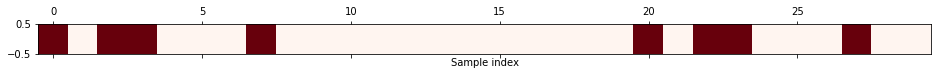

In [16]:
from sklearn.ensemble import RandomForestClassifier

X, y = load_breast_cancer(return_X_y=True)
#基于树模型进行模型选择
clf = RandomForestClassifier(n_estimators=100, random_state=10)
clf = clf.fit(X, y)

# 选择特征重要性为1.2倍均值的特征
model = SelectFromModel(clf, threshold='1.2*mean',prefit=True)

#返回所选的特征
X_trees = model.transform(X)
print('shape:{:}--->shape:{:}'.format(X.shape, X_trees.shape))

mask = model.get_support()
plt.matshow(mask.reshape(1, -1), cmap=plt.cm.Reds)#, aspect='auto')
plt.xlabel('Sample index')
plt.ylim(-0.5, 0.5)
plt.yticks([-0.5, 0.5])
plt.show()